In [43]:
%matplotlib inline
from matplotlib import style
style.use('tableau-colorblind10')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc, distinct

In [44]:
engine = create_engine("sqlite:///hawaii.sqlite")

# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB

session = Session(engine)

In [45]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [46]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [47]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [48]:
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [49]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


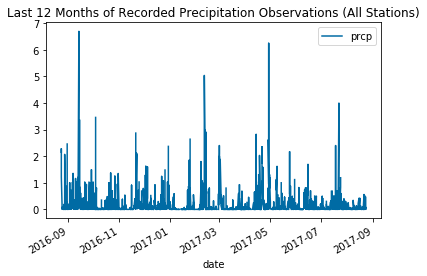

In [50]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
    
prev_year_prcp = pd.read_sql_query("SELECT date, prcp FROM measurement WHERE date > '2016-08-23'", engine)

prev_year_prcp.date = pd.to_datetime(prev_year_prcp.date,
                                     yearfirst = True)

prev_year_prcp.plot(x = 'date',
                    y = 'prcp',
                    title = "Last 12 Months of Recorded Precipitation Observations (All Stations)")

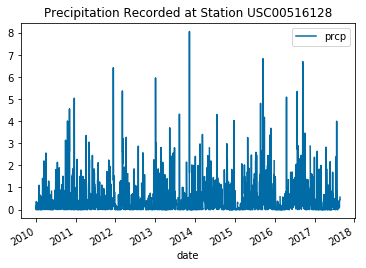

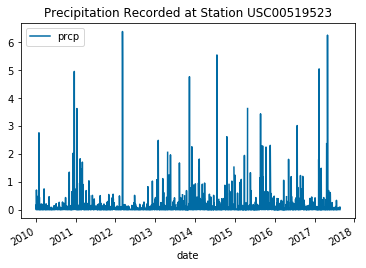

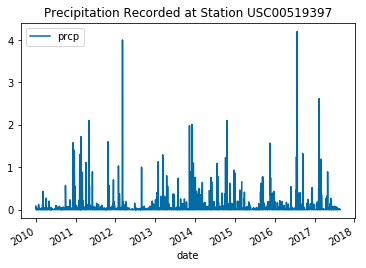

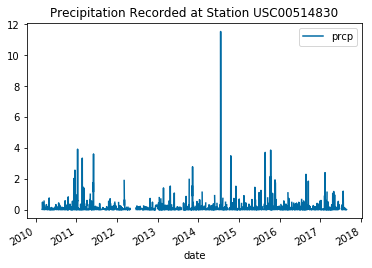

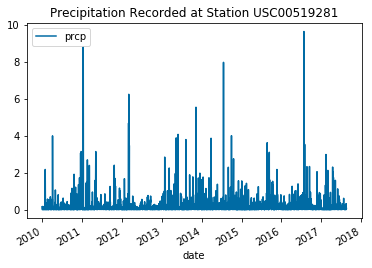

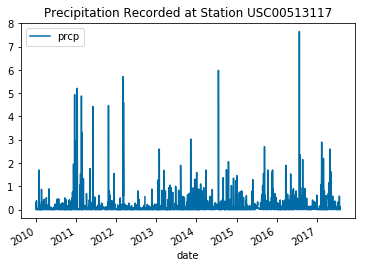

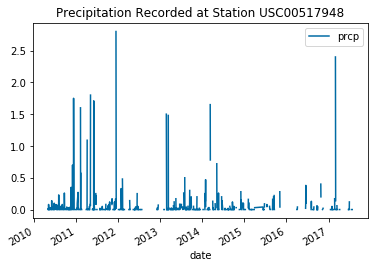

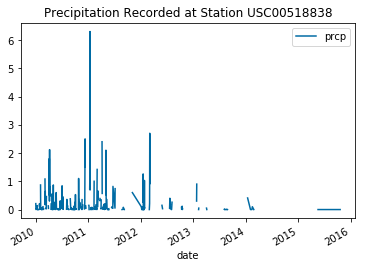

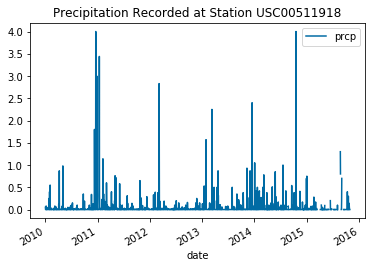

In [51]:
# Calculate the date 1 year ago from the last data point in the database

prev_year = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores

date_and_prcp_query = session.query(Measurement.date,
                                    Measurement.prcp)

# Save the query results as a Pandas DataFrame and set the index to the date column

measurement_df = pd.read_sql_query("SELECT * FROM measurement", engine, index_col = 'date')

# Sort the dataframe by date

measurement_df.sort_index(ascending = False, inplace = True)

measurement_df.reset_index(inplace = True)

measurement_df.date = pd.to_datetime(measurement_df.date,
                                     yearfirst = True)

# Use Pandas Plotting with Matplotlib to plot the data

for i in measurement_df.station.unique():
    measurement_df[measurement_df.station == i].plot(x = 'date',
                                                     y = 'prcp',
                                                     title = "Precipitation Recorded at Station " + i)

In [52]:
# Use Pandas to print the summary statistics for the precipitation data

for i in measurement_df.station.unique():
    
    test = measurement_df[measurement_df.station == i]
    
    print("Summary Stats for Precipitation Recorded at Station "\
          + i\
          + "\n"\
          + "-"\
          * len("Summary Stats for Precipitation Recorded at Station " + i)\
          + "\n",
          test.prcp.describe(),
          "\n")

Summary Stats for Precipitation Recorded at Station USC00516128
---------------------------------------------------------------
 count    2484.000000
mean        0.429988
std         0.712999
min         0.000000
25%         0.010000
50%         0.160000
75%         0.540000
max         8.060000
Name: prcp, dtype: float64 

Summary Stats for Precipitation Recorded at Station USC00519523
---------------------------------------------------------------
 count    2572.000000
mean        0.114961
std         0.410237
min         0.000000
25%         0.000000
50%         0.000000
75%         0.070000
max         6.380000
Name: prcp, dtype: float64 

Summary Stats for Precipitation Recorded at Station USC00519397
---------------------------------------------------------------
 count    2685.000000
mean        0.049020
std         0.210583
min         0.000000
25%         0.000000
50%         0.000000
75%         0.020000
max         4.200000
Name: prcp, dtype: float64 

Summary Stats for Prec

In [53]:
# Design a query to calculate the total number of stations

session.query(Measurement.station)\
       .group_by(Measurement.station)\
       .count()

9

In [54]:
# Design a query to find the most active stations

session.query(Measurement.station, func.count(Measurement.station))\
       .group_by(Measurement.station)\
       .order_by(desc(func.count(Measurement.station)))

# List the stations and observation counts in descending order

for i in session.query(Measurement.station, func.count(Measurement.station))\
                .group_by(Measurement.station)\
                .order_by(desc(func.count(Measurement.station))):
                    print(i)
    
# Which station has the highest number of observations?

for i in session.query(Measurement.station, func.count(Measurement.station))\
                .group_by(Measurement.station)\
                .order_by(desc(func.count(Measurement.station)))\
                .limit(1):
                    print("\nThe station with the highest number of observations is: " + i[0])

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)

The station with the highest number of observations is: USC00519281


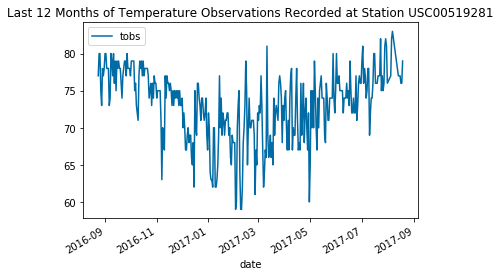

In [55]:
prev_year_tobs = pd.read_sql_query("SELECT * FROM measurement WHERE date > '2016-08-23'", engine)

prev_year_tobs.date = pd.to_datetime(prev_year_tobs.date,
                                     yearfirst = True)

prev_year_tobs = prev_year_tobs[prev_year_tobs.station == 'USC00519281']

prev_year_tobs.plot(x = 'date',
                    y = 'tobs',
                    title = "Last 12 Months of Temperature Observations Recorded at Station USC00519281")

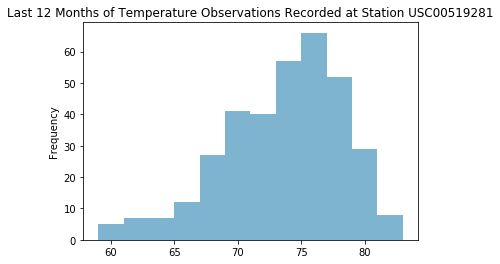

In [56]:
# Plot the results as a histogram with bins = 12

prev_year_tobs['tobs'].plot.hist(bins = 12,
                                 alpha = 0.5,
                                 title = "Last 12 Months of Temperature Observations Recorded at Station USC00519281")